<a href="https://colab.research.google.com/github/AmishaSingh0210/IPL_Data_Analysis/blob/main/Framingham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, precision_score, recall_score

#from pycaret.regression import setup, compare_models
from sklearn.model_selection import KFold, cross_val_score


In [3]:
data = pd.read_csv("framingham.csv")
data

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


In [4]:
data1 = data.copy()

In [5]:
data1 = data.drop(["education"],axis=1)

In [6]:
data1.isna().sum()

male                 0
age                  0
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [7]:
data1 = data1.dropna(subset=["cigsPerDay"])
data1 = data1.dropna(subset=["BPMeds"])
data1 = data1.dropna(subset=["totChol"])
data1 = data1.dropna(subset=["BMI"])
data1 = data1.dropna(subset=["heartRate"])

In [8]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target] ##all the values of column(na_target) that are not missing.
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns] ##all the other column(leaving na_target) with no missing value
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [9]:
data1 = knn_impute(data1,"glucose")

In [10]:
data1.isna().sum().sum()

0

In [11]:
data1 = data1.reset_index(drop=True)

**PICKING TARGET**

In [12]:
data2 = data1.copy()

In [13]:
target = data2["TenYearCHD"]
target

0       0
1       0
2       0
3       1
4       0
       ..
4083    1
4084    1
4085    0
4086    0
4087    0
Name: TenYearCHD, Length: 4088, dtype: int64

In [14]:
data2 = data2.drop(["TenYearCHD"],axis=1)
data2.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0


**DATA VISUALIZATION**

Text(0.5, 0, 'Heart Attack risk')

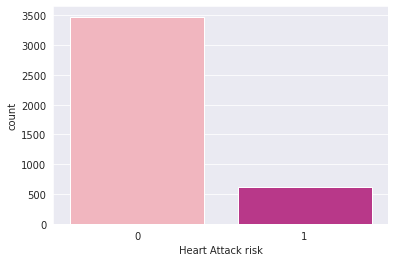

In [15]:
sns.countplot(x = target, palette= 'RdPu')
plt.xlabel('Heart Attack risk')

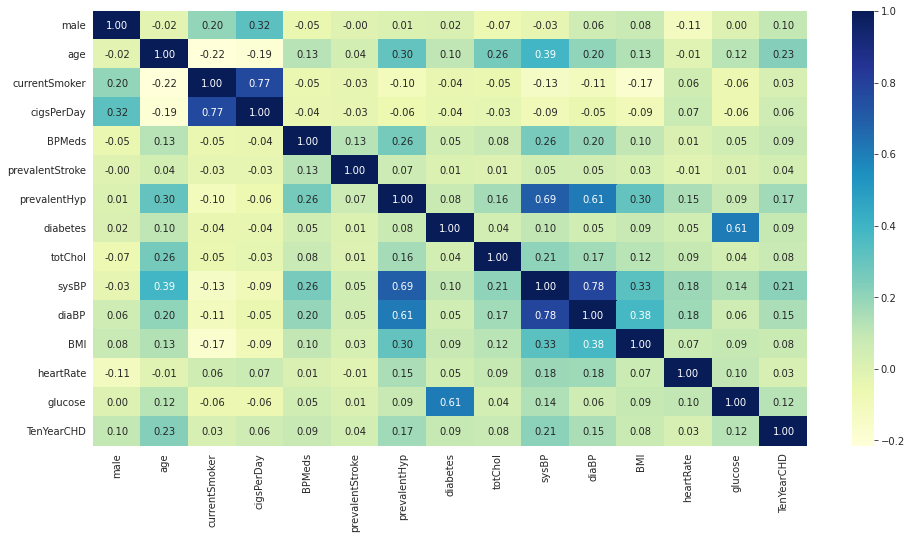

In [16]:
plt.figure(figsize= (16, 8))
sns.heatmap(data1.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f');

**FEATURE SCALING**

In [17]:
data3 = data2.copy()
sc = StandardScaler()
data3[["age",
"cigsPerDay",
"totChol",
"sysBP",
"diaBP",
"BMI",
"heartRate",
"glucose"]] = sc.fit_transform(data3[["age","cigsPerDay","totChol","sysBP","diaBP","BMI","heartRate","glucose"]])
data3.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,-1.229971,0,-0.755064,0.0,0,0,0,-0.937495,-1.197246,-1.088672,0.287219,0.345170,-0.208090
1,0,-0.410334,0,-0.755064,0.0,0,0,0,0.299536,-0.512432,-0.159498,0.718865,1.588610,-0.251529
2,1,-0.176152,1,0.924270,0.0,0,0,0,0.187079,-0.215679,-0.243968,-0.112544,-0.069310,-0.512159
3,0,1.346031,1,1.763937,0.0,0,1,0,-0.262751,0.811541,1.023087,0.682077,-0.898269,0.921310
4,0,-0.410334,1,1.176170,0.0,0,0,0,1.086737,-0.101544,0.093913,-0.661912,0.759650,0.139417


**DATA SPLITING**

In [18]:
data4 = data3.copy()
X_train, X_test, y_train, y_test = train_test_split(data4, target, test_size = 0.2)
X_train.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
3905,1,-0.995789,1,0.924270,0.0,0,0,0,-0.690089,-0.375469,0.516265,0.449087,0.345170,-0.512159
749,1,-1.112880,1,0.504437,0.0,0,0,0,0.209570,0.400653,1.614380,0.091016,0.759650,-0.642475
1108,0,1.580213,0,-0.755064,0.0,0,1,0,1.761481,1.085467,0.600735,0.029703,-0.981165,-0.338405
133,0,-0.995789,1,1.763937,0.0,0,1,0,-1.117427,0.994158,1.445439,-1.299572,-0.815373,-0.164652
3749,0,0.409303,0,-0.755064,0.0,0,1,0,0.794348,1.496355,1.023087,0.765464,2.003089,0.790994


In [19]:
y_train.head()

3905    0
749     0
1108    0
133     1
3749    0
Name: TenYearCHD, dtype: int64

In [20]:
X_test.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
917,1,-0.176152,1,1.763937,0.0,0,0,0,-1.949611,-0.215679,-0.666320,0.196475,-0.069310,1.312256
2409,1,0.409303,0,-0.755064,0.0,0,1,0,-0.397700,0.400653,1.867791,0.260241,-1.146957,-0.946544
2351,0,0.526394,0,-0.755064,0.0,0,0,0,0.367010,-0.238507,-1.215377,-0.799254,-0.483790,-0.251529
30,1,-1.581244,1,2.183771,0.0,0,0,0,1.311652,-1.379863,-1.257612,0.576618,-1.312749,-0.816228
3827,1,1.697304,0,-0.755064,0.0,0,1,1,-0.937495,1.998552,-0.412909,-0.220456,1.588610,12.519375


In [21]:
y_test.head()

917     0
2409    0
2351    0
30      0
3827    0
Name: TenYearCHD, dtype: int64

In [22]:
lr = LogisticRegression(random_state = 0)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
train_pred = lr.predict(X_train)

In [23]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[681   2]
 [121  14]]


0.8496332518337408